# **Проект: прогнозирование заработной платы и кластеризация типов движений**

# **Часть 1. Прогнозирование заработной платы при помощи бустинга**


## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
!pip install catboost

In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA

from multiprocessing import Pool
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,\
                            silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

from time import time
import joblib

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [ ]:
df

work_year experience_level employment_type                 job_title  \
0          2023               SE              FT  Principal Data Scientist   
1          2023               MI              CT               ML Engineer   
2          2023               MI              CT               ML Engineer   
3          2023               SE              FT            Data Scientist   
4          2023               SE              FT            Data Scientist   
...         ...              ...             ...                       ...   
3750       2020               SE              FT            Data Scientist   
3751       2021               MI              FT  Principal Data Scientist   
3752       2020               EN              FT            Data Scientist   
3753       2020               EN              CT     Business Data Analyst   
3754       2021               SE              FT      Data Science Manager   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0       80000             EUR          85847                 ES           100   
1       30000             USD          30000                 US           100   
2       25500             USD          25500                 US           100   
3      175000             USD         175000                 CA           100   
4      120000             USD         120000                 CA           100   
...       ...             ...            ...                ...           ...   
3750   412000             USD         412000                 US           100   
3751   151000             USD         151000                 US           100   
3752   105000             USD         105000                 US           100   
3753   100000             USD         100000                 US           100   
3754  7000000             INR          94665                 IN            50   

     company_location company_size  
0                  ES            L  
1                  US            S  
2                  US            S  
3                  CA            M  
4                  CA            M  
...               ...          ...  
3750               US            L  
3751               US            L  
3752               US            S  
3753               US            L  
3754               IN            L  

[3755 rows x 11 columns]

Напишу цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
categorical_variables = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'remote_ratio': [0, 50, 100],
    'company_size': ['S', 'M', 'L']
    }

In [ ]:
for col in df.columns:
    if col in categorical_variables.keys():
        allowed = set(categorical_variables[col])
        actual = set(df[col].unique())
        invalid = actual - allowed
        if invalid:
            print(f"Ошибка в признаке {col}: недопустимые значения {invalid}")
        else:
            print(f"Признак {col} корректен. Допустимые значения: {allowed}")

Признак experience_level корректен. Допустимые значения: {'EN', 'SE', 'MI', 'EX'}
Признак employment_type корректен. Допустимые значения: {'FT', 'FL', 'CT', 'PT'}
Признак remote_ratio корректен. Допустимые значения: {0, 50, 100}
Признак company_size корректен. Допустимые значения: {'S', 'L', 'M'}


Провожу базовые шаги оценки качества данных.
- Есть есть проблемы, устраняю их;
- Если нет проблем, кратко описываю.

In [ ]:
df.shape

(3755, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
# Изменим типа данных некоторых признаков (из задания 1) на категориальные
for col in df.columns:
    if col in categorical_variables:
        df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           3755 non-null   int64   
 1   experience_level    3755 non-null   category
 2   employment_type     3755 non-null   category
 3   job_title           3755 non-null   object  
 4   salary              3755 non-null   int64   
 5   salary_currency     3755 non-null   object  
 6   salary_in_usd       3755 non-null   int64   
 7   employee_residence  3755 non-null   object  
 8   remote_ratio        3755 non-null   category
 9   company_location    3755 non-null   object  
 10  company_size        3755 non-null   category
dtypes: category(4), int64(3), object(4)
memory usage: 220.8+ KB


In [ ]:
# Смотрим на количество пропусков в каждом столбце
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [ ]:
df.describe()

work_year        salary  salary_in_usd
count  3755.000000  3.755000e+03    3755.000000
mean   2022.373635  1.906956e+05  137570.389880
std       0.691448  6.716765e+05   63055.625278
min    2020.000000  6.000000e+03    5132.000000
25%    2022.000000  1.000000e+05   95000.000000
50%    2022.000000  1.380000e+05  135000.000000
75%    2023.000000  1.800000e+05  175000.000000
max    2023.000000  3.040000e+07  450000.000000

In [ ]:
df.describe(include=['object', 'category'])

experience_level employment_type      job_title salary_currency  \
count              3755            3755           3755            3755   
unique                4               4             93              20   
top                  SE              FT  Data Engineer             USD   
freq               2516            3718           1040            3224   

       employee_residence  remote_ratio company_location company_size  
count                3755          3755             3755         3755  
unique                 78             3               72            3  
top                    US             0               US            M  
freq                 3004          1923             3040         3153

Теперь посмотрим на выбросы  в числовых столбцах.

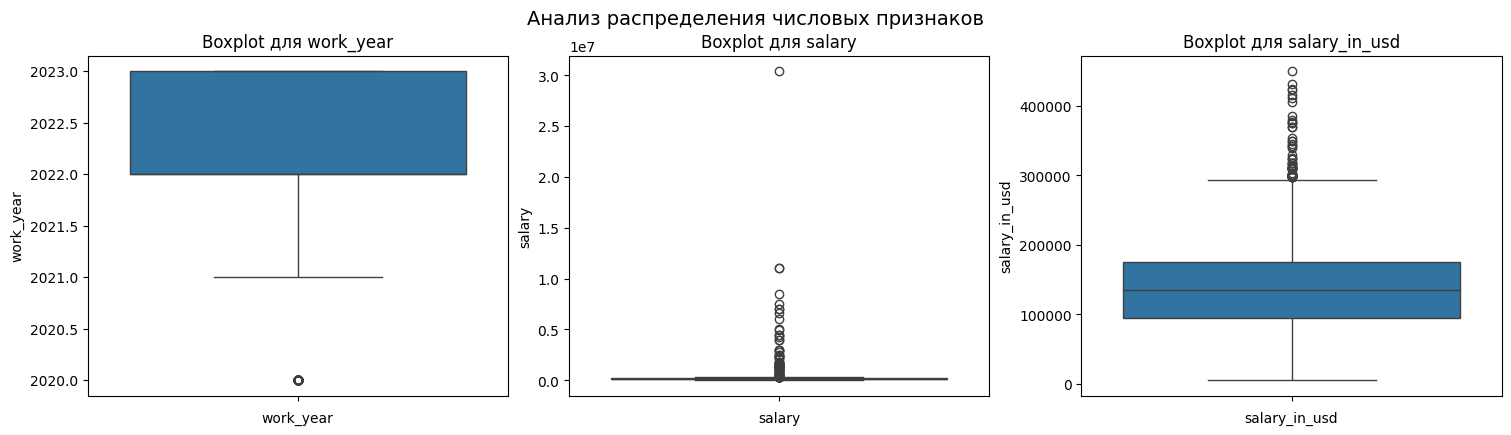

In [ ]:
int_cols = df.select_dtypes(include=['number']).columns.tolist()
# Определяем количество строк и столбцов для графиков
plots = len(int_cols)
cols = 3
rows = (plots + cols - 1) // cols

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(15, rows * 4),
                         constrained_layout=True)
axes = axes.flatten()
for i in range(plots, len(axes)):
    axes[i].remove()

for i, col in enumerate(int_cols):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_xlabel(col)

plt.suptitle('Анализ распределения числовых признаков', y=1.05, fontsize=14)
plt.show()

Как можно заметить, самое большое количество выбросов по salary. Посмотрим на количество выбросов.

In [ ]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.01)
    Q3 = data.quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

for col in int_cols:
    outliers = find_outliers_iqr(df[col])
    print(f'Столбец {col} с {len(outliers)} выбросами')

Столбец work_year с 0 выбросами
Столбец salary с 16 выбросами
Столбец salary_in_usd с 0 выбросами


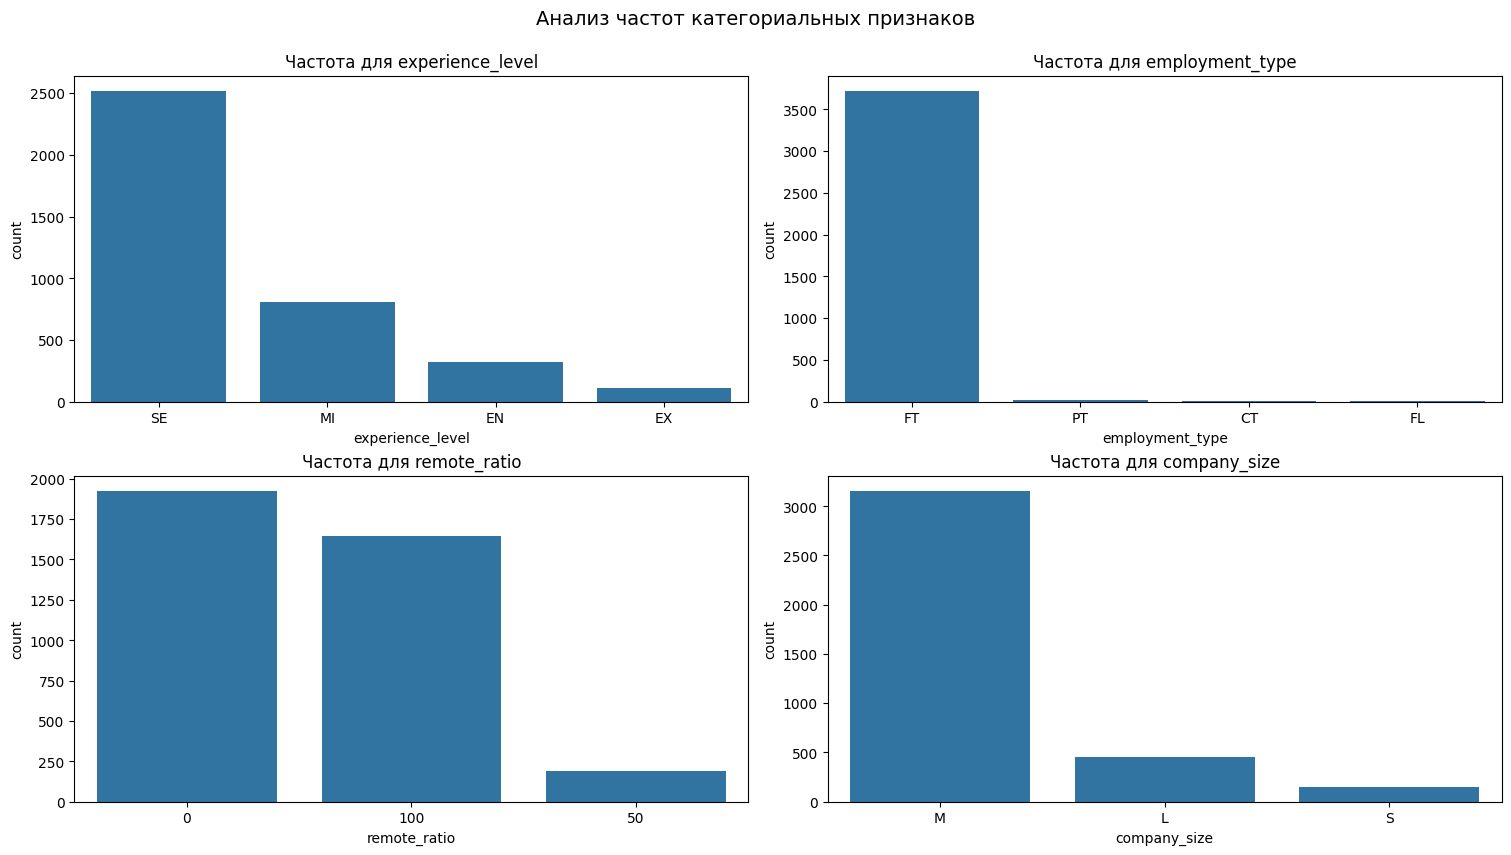

In [ ]:
plots = len(categorical_variables)
cols = 2
rows = (plots + cols - 1) // cols

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(15, rows * 4),
                         constrained_layout=True)
axes = axes.flatten()
for i in range(plots, len(axes)):
    axes[i].remove()

for i, col in enumerate(categorical_variables):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Частота для {col}')
    axes[i].set_xlabel(col)


plt.suptitle('Анализ частот категориальных признаков', y=1.05, fontsize=14)
plt.show()

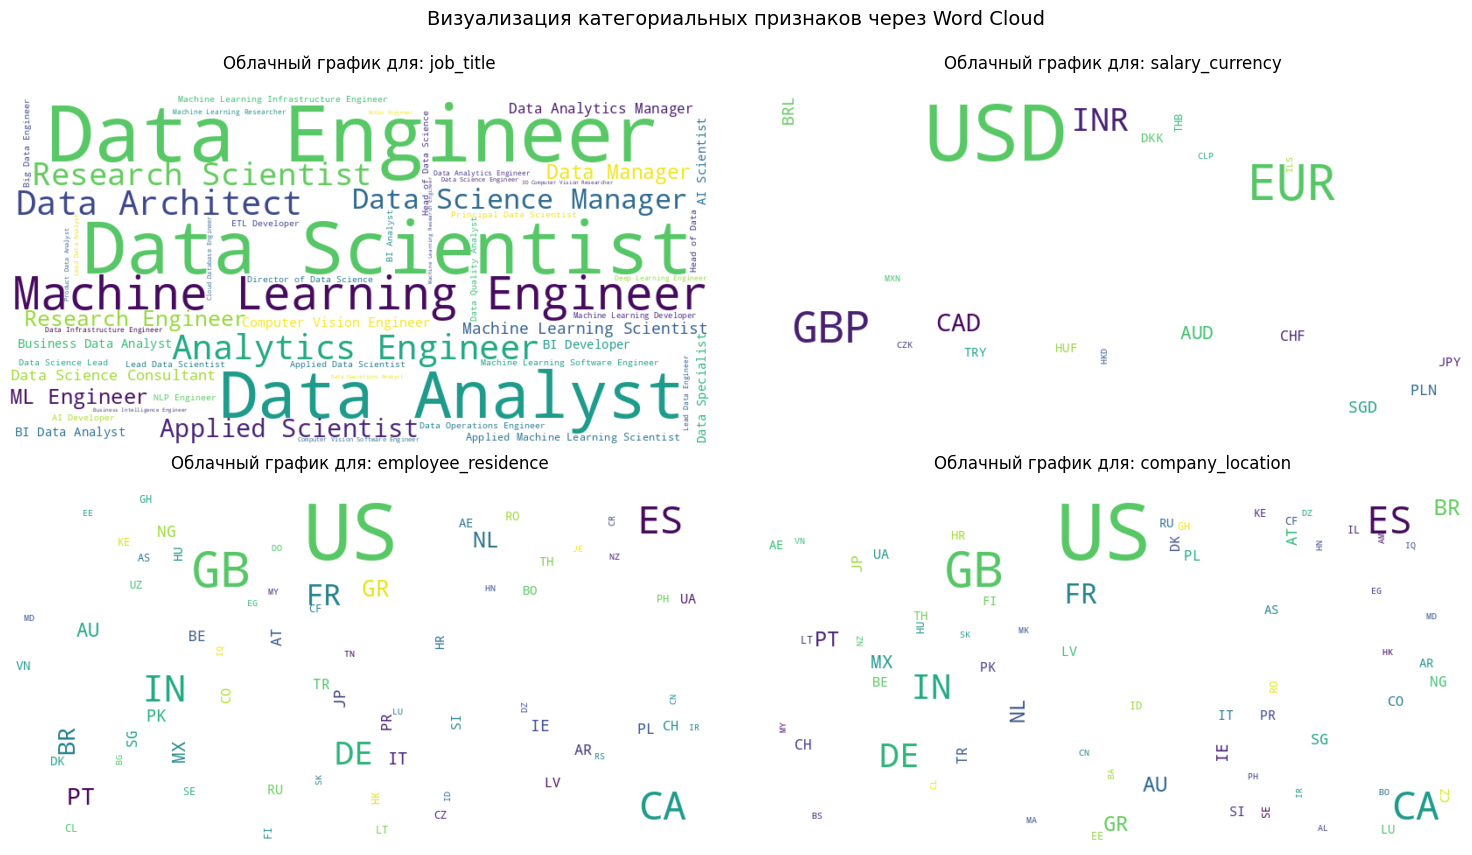

In [ ]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()
# Определяем количество строк и столбцов для графиков
plots = len(object_cols)
cols = 2
rows = (plots + cols - 1) // cols

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=rows,
                         ncols=cols,
                         figsize=(15, rows * 4),
                         constrained_layout=True)
axes = axes.flatten()
for i in range(plots, len(axes)):
    axes[i].remove()

for i, col in enumerate(object_cols):
    frequencies = df[col].astype(str).value_counts().to_dict()

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=70,          # Ограничиваем количество отображаемых категорий
        margin=1,           # Минимальное расстояние между словами
        relative_scaling=0.4,
        prefer_horizontal=0.7,
        min_font_size=6,
        max_font_size=90,
        random_state=42
    ).generate_from_frequencies(frequencies)

    ax = axes[i]
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Облачный график для: {col}', pad=20, fontsize=12)

plt.suptitle('Визуализация категориальных признаков через Word Cloud', y=1.05, fontsize=14)
plt.show()

Итоги оценки качества данных:
* Пропущенных значений нет
* Поменяли типы данных для некоторых переменных
* Описательная статистика явных отклонений не показывает
* Большие выбросы есть только у переменной salary, но это может быть связано с валютной разницей тк в salary_in_usd выбросов нет.
* При обучении могут возникнуть проблемы с масштабами тк у зп нет ограничений, поэтому придется масштабировать признаки.

Вернусь к описанию признаков.
- Проверю, все ли признаки соответствуют постановке задачи. Если есть лишние признаки, удалю, обосновав удаление, если нет, делаем вывод о релевантности 
- Фиксируем, в каких признаках много категорий.

Тк целевая переменная у нас - это предсказание цены в долларах, то наша модель может содержать прямую информацию о целевой переменной, если у нее будут данные о salary и salary_currency (модель легко найдет зависимость и будет смотреть только на эти данные), поэтому их нужно удалить.\
Также job_title имеет 93 уникальных значения. Это очень много и может привести к переобучению, поэтому можно сделать так: если должность встречается < 10 раз, тогда объединияем в "Other".\
Если у нас больше 90% данных попадают под условие employee_residence == company_location, то нужно удалить один из столбцов (это может произойти из-за того, что сотрудники часто живут в той же стране, где находится компания).\
**Итог:** удаляем salary и salary_currency, группируем job_title, проверяем employee_residence == company_location

In [ ]:
df = df.drop(['salary', 'salary_currency'], axis=1)

In [ ]:
job_counts = df['job_title'].value_counts()
job_counts

job_title
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: count, Length: 93, dtype: int64

In [ ]:
top_jobs = job_counts[job_counts >= 10].index
df['job_title'] = np.where(df['job_title'].isin(top_jobs), df['job_title'], 'Other')

In [ ]:
print(f"Уникальных значений после замены: {df['job_title'].nunique()}")
print(f"Пример частот после замены:\n {df['job_title'].value_counts()}")

Уникальных значений после замены: 32
Пример частот после замены:
 job_title
Data Engineer                               1040
Data Scientist                               840
Data Analyst                                 612
Machine Learning Engineer                    289
Other                                        203
Analytics Engineer                           103
Data Architect                               101
Research Scientist                            82
Applied Scientist                             58
Data Science Manager                          58
Research Engineer                             37
ML Engineer                                   34
Data Manager                                  29
Machine Learning Scientist                    26
Data Science Consultant                       24
Data Analytics Manager                        22
Computer Vision Engineer                      18
AI Scientist                                  16
BI Data Analyst                           

In [ ]:
count = 0
for i in range(len(df)):
    if df['employee_residence'][i] == df['company_location'][i]:
        count += 1

print(f'Процент соответствия столбцов: {round(count/len(df) * 100)}%')

Процент соответствия столбцов: 97%


Удалем столбец employee_residence тк зп зависит от места компании, а не от места жительства человека.

In [ ]:
df = df.drop(['employee_residence'], axis=1)

In [ ]:
# количество уникальных категорий в признаках
unique_counts = df.nunique()
unique_counts.sort_values(ascending=False)

salary_in_usd       1035
company_location      72
job_title             32
work_year              4
experience_level       4
employment_type        4
remote_ratio           3
company_size           3
dtype: int64

Разделяем выборку на train, test (80%, 20%).

In [ ]:
X = df.drop(columns='salary_in_usd', axis=1)
y = df['salary_in_usd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. Для этого нужно подготовить данные

- Выделить данные для тренировки и теста для непрерывных признаков
- Выделить данные для тренировки и теста для непрерывных + категориальных признаков

In [ ]:
# неприрывные признаки
X_train_cont, X_test_cont = X_train[['work_year']], X_test[['work_year']]

In [ ]:
# Проверка размерностей
print(f"Сценарий 1 (непрерывные): {X_train_cont.shape[1]} признак")
print(f"Сценарий 2 (полный): {X_train.shape[1]} признаков")

Сценарий 1 (непрерывные): 1 признак
Сценарий 2 (полный): 7 признаков


- Обучаем модель линейной регресии на числовых признаках и оцениваем её качество через mape и rmse;
- Делаем вывод о качестве построенной модели;

In [ ]:
# Сначала стандартизируем данные
def standardize_data(Xtrain, Xtest):
  scaler = StandardScaler()

  Xtrain_scaled = scaler.fit_transform(Xtrain)
  Xtest_scaled = scaler.transform(Xtest)

  Xtrain = pd.DataFrame(Xtrain_scaled, columns=Xtrain.columns)
  Xtest = pd.DataFrame(Xtest_scaled, columns=Xtest.columns)

  return Xtrain, Xtest

X_train_cont, X_test_cont = standardize_data(X_train_cont, X_test_cont)

In [ ]:
model = LinearRegression()
# Обучаем только на числовых признаках
model.fit(X_train_cont, y_train)

y_pred = model.predict(X_test_cont)

In [ ]:
# Оценка качества
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f} USD")

MAPE: 70.65%
RMSE: 3764814231.13 USD


Как можно заметить, модель ошибается в 71% данных, что не удивительно тк мы обучаемся только на одном числовом признаке. Также по значению rmse можно понять, что мы ошибаемся примерно на 3764814231 долларов. Все это говорит об очень плохом качестве модели.

- Обучаем модель бустинга с гиперпараметрами по умолчанию на непрерывных признаках и оценим её качество через mape и rmse;
- Делаем вывод о качестве построенной модели;

In [ ]:
model = CatBoostRegressor(verbose=False, random_state=42)
model.fit(X_train_cont, y_train)

y_pred = model.predict(X_test_cont)

In [ ]:
# Оценка качества
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f} USD")

MAPE: 70.66%
RMSE: 3796671221.74 USD


Результат по прежнему плохой

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработка категориальных признаков при помощи OHE
- Построение модели бустинга и линейной регрессии
- Оценка качества обеих моделей

**2:**
- Предобработка категориальных признаков при помощи LabelEncoding
- Построение модели бустинга и линейной регрессии
- Оценка качества обеих моделей

**3:**
- Предобработка категориальных признаков при помощи MeanTargetEnc
- Построение модели бустинга и линейной регрессии
- Оценка качества обеих моделей

Делаю выводы по построениям 1-3. Выбираю лучшую модель и дальше работаю с ней.

In [ ]:
categorical_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Кодировка категориальных признаков методом OHE с удалением одного столбца
X_train_OHE = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)
all_ohe_columns = X_train_OHE.columns
X_test_OHE = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=int)
X_test_OHE = X_test_OHE.reindex(columns=all_ohe_columns, fill_value=0)

# Кодировка категориальных признаков методом LabelEncoding
X_train_LE = X_train.copy()
X_test_LE = X_test.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_LE[col] = le.fit_transform(X_train_LE[col])
    X_test_LE[col] = X_test_LE[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le

# Кодировка категориальных признаков методом MeanTargetEnc
mt_encoder = TargetEncoder(cols=categorical_cols, smoothing=1.0)

X_train_MT = mt_encoder.fit_transform(X_train[categorical_cols], y_train)
X_test_MT = mt_encoder.transform(X_test[categorical_cols])

X_train_MT = pd.DataFrame(X_train_MT, columns=categorical_cols)
X_test_MT = pd.DataFrame(X_test_MT, columns=categorical_cols)

X_train_MT[numeric_cols] = X_train[numeric_cols].values
X_test_MT[numeric_cols] = X_test[numeric_cols].values

# Стандартизируем данные
X_train_OHE, X_test_OHE = standardize_data(X_train_OHE, X_test_OHE)
X_train_LE, X_test_LE = standardize_data(X_train_LE, X_test_LE)
X_train_MT, X_test_MT = standardize_data(X_train_MT, X_test_MT)

In [ ]:
# Модели для OHE
lr_ohe = LinearRegression().fit(X_train_OHE, y_train)
xgb_ohe = CatBoostRegressor().fit(X_train_OHE, y_train)

# Модели для LabelEncoding
lr_le = LinearRegression().fit(X_train_LE, y_train)
xgb_le = CatBoostRegressor().fit(X_train_LE, y_train)

# Модели для MeanTargetEnc
lr_mt = LinearRegression().fit(X_train_MT, y_train)
xgb_mt = CatBoostRegressor().fit(X_train_MT, y_train)

# Предсказание
y_pred_lr_ohe = lr_ohe.predict(X_test_OHE)
y_pred_xgb_ohe = xgb_ohe.predict(X_test_OHE)

y_pred_lr_le = lr_le.predict(X_test_LE)
y_pred_xgb_le = xgb_le.predict(X_test_LE)

y_pred_lr_mt = lr_mt.predict(X_test_MT)
y_pred_xgb_mt = xgb_mt.predict(X_test_MT)

Learning rate set to 0.048714
0:	learn: 62013.4626371	total: 4.57ms	remaining: 4.57s
1:	learn: 61042.7432197	total: 8.52ms	remaining: 4.25s
2:	learn: 60131.0274456	total: 11.1ms	remaining: 3.68s
3:	learn: 59308.6002041	total: 12.8ms	remaining: 3.19s
4:	learn: 58683.1403725	total: 18.6ms	remaining: 3.7s
5:	learn: 58068.8300900	total: 20.6ms	remaining: 3.41s
6:	learn: 57404.5311535	total: 23ms	remaining: 3.26s
7:	learn: 56841.5562717	total: 29.1ms	remaining: 3.6s
8:	learn: 56324.2301709	total: 30.9ms	remaining: 3.4s
9:	learn: 55783.9155172	total: 36.9ms	remaining: 3.66s
10:	learn: 55332.6638461	total: 39.5ms	remaining: 3.55s
11:	learn: 54927.8974754	total: 43.8ms	remaining: 3.61s
12:	learn: 54551.6480056	total: 47.9ms	remaining: 3.63s
13:	learn: 54159.4343593	total: 49.6ms	remaining: 3.5s
14:	learn: 53827.1811136	total: 55.7ms	remaining: 3.66s
15:	learn: 53531.3424565	total: 57.4ms	remaining: 3.53s
16:	learn: 53243.9505185	total: 61.2ms	remaining: 3.54s
17:	learn: 52961.7787261	total: 67

In [ ]:
# Оценка
print(f"OHE Linear Regression - MAPE: {mean_absolute_percentage_error(y_test, y_pred_lr_ohe):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_ohe)):.2f}")
print(f"OHE CatBoost Regressor - MAPE: {mean_absolute_percentage_error(y_test, y_pred_xgb_ohe):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_ohe)):.2f}")
print("\n")
print(f"LE Linear Regression - MAPE: {mean_absolute_percentage_error(y_test, y_pred_lr_le):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_le)):.2f}")
print(f"LE CatBoost Regressor - MAPE: {mean_absolute_percentage_error(y_test, y_pred_xgb_le):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_le)):.2f}")
print("\n")
print(f"MT Linear Regression - MAPE: {mean_absolute_percentage_error(y_test, y_pred_lr_mt):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_mt)):.2f}")
print(f"MT CatBoost Regressor - MAPE: {mean_absolute_percentage_error(y_test, y_pred_xgb_mt):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_mt)):.2f}")

OHE Linear Regression - MAPE: 39.37%, RMSE: 49409.51
OHE CatBoost Regressor - MAPE: 38.63%, RMSE: 48578.81


LE Linear Regression - MAPE: 52.84%, RMSE: 53847.75
LE CatBoost Regressor - MAPE: 37.75%, RMSE: 48750.06


MT Linear Regression - MAPE: 41.78%, RMSE: 50044.26
MT CatBoost Regressor - MAPE: 37.40%, RMSE: 47570.13


Лучшая модель MeanTargetEnc + CatBoost Regressor:\
У этой модели самое лучшее значения RMSE и MAPE из всех.

Покажу, где ошибается модель. Выведу топ 20 примеров с наибольшей ошибкой. Проанализирую их. Сделаю выводы. 

In [ ]:
errors = abs(y_pred_xgb_ohe - y_test)
top_20_errors = X_test.copy()
top_20_errors['errors'] = errors
top_20_errors = top_20_errors.sort_values(by='errors', ascending=False).head(20)
top_20_errors

work_year experience_level employment_type                   job_title  \
1288       2023               SE              FT                Data Analyst   
2359       2022               SE              FT                       Other   
1105       2023               SE              FT              Data Scientist   
3609       2020               SE              FT  Machine Learning Scientist   
478        2023               EX              FT    Director of Data Science   
1116       2023               SE              FT   Machine Learning Engineer   
3470       2022               SE              FT      Applied Data Scientist   
1593       2023               SE              FT               Data Engineer   
33         2023               SE              FT    Computer Vision Engineer   
218        2023               SE              FT      Applied Data Scientist   
3649       2021               SE              FT        Data Science Manager   
3387       2022               SE              FT               Data Engineer   
325        2023               MI              FT   Machine Learning Engineer   
2711       2022               EX              FT               Data Engineer   
3701       2021               SE              FT          Research Scientist   
746        2023               EX              FT               Data Engineer   
1677       2023               SE              FT              Data Scientist   
2009       2022               SE              FT   Machine Learning Engineer   
811        2023               MI              FT        Data Science Manager   
183        2020               EX              FT                       Other   

     remote_ratio company_location company_size         errors  
1288            0               US            M  256348.451859  
2359           50               US            L  207039.970154  
1105            0               US            M  201190.234584  
3609            0               JP            S  155524.298777  
478             0               US            M  147303.439662  
1116            0               US            M  147186.675661  
3470          100               US            L  145520.799672  
1593            0               US            M  142333.396779  
33              0               US            M  137667.286097  
218           100               FI            M  137611.939675  
3649           50               US            L  136069.405984  
3387          100               US            M  130538.595083  
325           100               US            M  127684.441796  
2711          100               US            M  125938.906198  
3701          100               US            S  125064.070875  
746           100               US            M  124682.716217  
1677          100               US            M  124510.636561  
2009          100               MX            M  124253.321455  
811             0               US            M  123059.155510  
183             0               CA            M  123048.695342

In [ ]:
for col in top_20_errors.columns[:-1]:
    first_value = top_20_errors[col].value_counts().index[0]
    first_count = top_20_errors[col].value_counts().iloc[0]
    print(f'{first_count} из 20 ошибок ({first_count * 5}%) приходится на {col} = "{first_value}"')

11 из 20 ошибок (55%) приходится на work_year = "2023"
14 из 20 ошибок (70%) приходится на experience_level = "SE"
20 из 20 ошибок (100%) приходится на employment_type = "FT"
4 из 20 ошибок (20%) приходится на job_title = "Data Engineer"
9 из 20 ошибок (45%) приходится на remote_ratio = "0"
16 из 20 ошибок (80%) приходится на company_location = "US"
15 из 20 ошибок (75%) приходится на company_size = "M"


В данных мало примеров с высоким уровнем опыта (EX встречается редко) и модель не улавливает, что в крупных компаниях зарплаты выше и недооценивает зарплаты в США. Это можно решить так:
* Закодировать company_size как порядковый признак (S=1, M=2, L=3)
* Добавить взаимодействие company_size * experience_level
* Заменить выбросы медианным значением.

Придумаю признаки для улучшения качества модели на основе предыдущего пункта

In [ ]:
# company_size как порядковый признак (S=1, M=2, L=3)
df_new = df.copy()
df_new['company_size_encoded'] = df_new['company_size'].replace({'S': 1, 'M': 2, 'L': 3})
df_new.head()

<ipython-input-335-e2b82daa0a7c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['company_size_encoded'] = df_new['company_size'].replace({'S': 1, 'M': 2, 'L': 3})
<ipython-input-335-e2b82daa0a7c>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_new['company_size_encoded'] = df_new['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


work_year experience_level employment_type       job_title  salary_in_usd  \
0       2023               SE              FT           Other          85847   
1       2023               MI              CT     ML Engineer          30000   
2       2023               MI              CT     ML Engineer          25500   
3       2023               SE              FT  Data Scientist         175000   
4       2023               SE              FT  Data Scientist         120000   

  remote_ratio company_location company_size company_size_encoded  
0          100               ES            L                    3  
1          100               US            S                    1  
2          100               US            S                    1  
3          100               CA            M                    2  
4          100               CA            M                    2

In [ ]:
# взаимодействие company_size * experience_level
df_new['experience_code'] = df_new['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
df_new[['company_size_encoded','experience_code']] = df_new[['company_size_encoded','experience_code']].astype('int')
df_new['company_experience_interaction'] = df_new['company_size_encoded'] * df_new['experience_code']
df_new = df_new.drop(['company_size', 'experience_level'], axis=1)
df_new.head()

<ipython-input-336-6467d233f6d3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['experience_code'] = df_new['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
<ipython-input-336-6467d233f6d3>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_new['experience_code'] = df_new['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})


work_year employment_type       job_title  salary_in_usd remote_ratio  \
0       2023              FT           Other          85847          100   
1       2023              CT     ML Engineer          30000          100   
2       2023              CT     ML Engineer          25500          100   
3       2023              FT  Data Scientist         175000          100   
4       2023              FT  Data Scientist         120000          100   

  company_location  company_size_encoded  experience_code  \
0               ES                     3                3   
1               US                     1                2   
2               US                     1                2   
3               CA                     2                3   
4               CA                     2                3   

   company_experience_interaction  
0                               9  
1                               2  
2                               2  
3                               6  
4                               6

In [ ]:
# Замена выбросов в зарплате медианным значением
Q1 = df_new['salary_in_usd'].quantile(0.25)
Q3 = df_new['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_salary = df_new['salary_in_usd'].median()

df_new['salary_in_usd'] = df_new['salary_in_usd'].apply(
    lambda x: median_salary if x < lower_bound or x > upper_bound else x
)

In [ ]:
print("До обработки:")
print(df['salary_in_usd'].describe())
print("\nПосле обработки:")
print(df_new['salary_in_usd'].describe())

До обработки:
count      3755.000000
mean     137570.389880
std       63055.625278
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      175000.000000
max      450000.000000
Name: salary_in_usd, dtype: float64

После обработки:
count      3755.000000
mean     134275.358988
std       57503.697142
min        5132.000000
25%       95000.000000
50%      135000.000000
75%      172254.500000
max      293000.000000
Name: salary_in_usd, dtype: float64


In [ ]:
# Обучим нашу самую лучшую модель на новых данных
X_new = df_new.drop(columns='salary_in_usd', axis=1)
y_new = df_new['salary_in_usd']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [ ]:
categorical_cols_new = ['employment_type', 'job_title', 'company_location', 'remote_ratio']
# Кодировка категориальных признаков методом MeanTargetEnc
mt_encoder = TargetEncoder(cols=categorical_cols_new, smoothing=1.0)

X_train_MT2 = mt_encoder.fit_transform(X_train_new[categorical_cols_new], y_train_new)
X_test_MT2 = mt_encoder.transform(X_test_new[categorical_cols_new])

X_train_MT2 = pd.DataFrame(X_train_MT2, columns=categorical_cols_new)
X_test_MT2 = pd.DataFrame(X_test_MT2, columns=categorical_cols_new)

X_train_MT2[numeric_cols] = X_train_new[numeric_cols].values
X_test_MT2[numeric_cols] = X_test_new[numeric_cols].values

# Стандартизируем данные
X_train_MT2, X_test_MT2 = standardize_data(X_train_MT, X_test_MT)

# Обучаем
xgb_mt2 = CatBoostRegressor().fit(X_train_MT2, y_train_new)

# Предсказываем
y_pred_xgb_mt2 = xgb_mt2.predict(X_test_MT2)

Learning rate set to 0.048714
0:	learn: 56288.7210320	total: 965us	remaining: 964ms
1:	learn: 55344.4097686	total: 1.79ms	remaining: 895ms
2:	learn: 54458.9359296	total: 2.61ms	remaining: 868ms
3:	learn: 53675.9035066	total: 3.32ms	remaining: 828ms
4:	learn: 52904.7012966	total: 4.04ms	remaining: 805ms
5:	learn: 52226.3434869	total: 4.81ms	remaining: 798ms
6:	learn: 51548.5315075	total: 5.54ms	remaining: 787ms
7:	learn: 50939.7117037	total: 6.23ms	remaining: 773ms
8:	learn: 50414.3428222	total: 6.93ms	remaining: 763ms
9:	learn: 49889.5231060	total: 7.59ms	remaining: 751ms
10:	learn: 49382.7554857	total: 8.27ms	remaining: 744ms
11:	learn: 48916.8110030	total: 8.96ms	remaining: 738ms
12:	learn: 48500.6429944	total: 9.65ms	remaining: 733ms
13:	learn: 48109.9345286	total: 10.3ms	remaining: 728ms
14:	learn: 47739.4478373	total: 11.1ms	remaining: 727ms
15:	learn: 47414.0013693	total: 11.8ms	remaining: 726ms
16:	learn: 47089.5472114	total: 12.6ms	remaining: 730ms
17:	learn: 46804.9701444	tota

In [ ]:
print("Было")
print(f"MT CatBoost Regressor - MAPE: {mean_absolute_percentage_error(y_test, y_pred_xgb_mt):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_mt)):.2f}")
print("Стало")
print(f"MT CatBoost Regressor - MAPE: {mean_absolute_percentage_error(y_test_new, y_pred_xgb_mt2):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_mt2)):.2f}")

Было
MT CatBoost Regressor - MAPE: 37.40%, RMSE: 47570.13
Стало
MT CatBoost Regressor - MAPE: 35.95%, RMSE: 44116.99



Поупражняюсь с разными бустингами!


In [ ]:
# обучаем CatBoost на всех преобразованных данных без кодировки
model_cbr_lite = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100
)

start_time = time()
model_cbr_lite.fit(X_train_new, y_train_new, cat_features=categorical_cols_new)
training_time = time() - start_time

print(f"Время обучения: {training_time:.2f} секунд")

0:	learn: 56104.8484418	total: 19.3ms	remaining: 19.2s
100:	learn: 41476.9043657	total: 879ms	remaining: 7.83s
200:	learn: 40309.3259253	total: 2.07s	remaining: 8.22s
300:	learn: 39385.8117103	total: 3.06s	remaining: 7.12s
400:	learn: 38586.6648140	total: 3.83s	remaining: 5.71s
500:	learn: 37929.7362945	total: 4.46s	remaining: 4.44s
600:	learn: 37289.8139305	total: 5.05s	remaining: 3.35s
700:	learn: 36736.0965433	total: 5.75s	remaining: 2.45s
800:	learn: 36296.4759979	total: 6.24s	remaining: 1.55s
900:	learn: 35782.7203626	total: 7.21s	remaining: 792ms
999:	learn: 35362.6696889	total: 7.95s	remaining: 0us
Время обучения: 8.17 секунд


In [ ]:
y_pred_cbr_lite = model_cbr_lite.predict(X_test_new)
rmse_cbr_lite = np.sqrt(mean_squared_error(y_test_new, y_pred_cbr_lite))
print(f"RMSE без подбора гиперпараметров: {rmse_cbr_lite:.2f}")

RMSE без подбора гиперпараметров: 44296.87


In [ ]:
# подбор гиперпараметров
model_cbr_search = CatBoostRegressor(cat_features=categorical_cols_new, verbose=0)

param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [500, 1000, 1500],
}

random_search = RandomizedSearchCV(
    estimator=model_cbr_search,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start_time = time()
random_search.fit(X_train_new, y_train_new)
end_time = time()

print("Лучшие гиперпараметры:", random_search.best_params_)
print(f"Время подбора гиперпараметров: {end_time - start_time:.2f} секунд")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие гиперпараметры: {'learning_rate': 0.01, 'iterations': 1500, 'depth': 6}
Время подбора гиперпараметров: 272.09 секунд


In [ ]:
# обучаем CatBoost на подобранных параметрах
best_model_cbr = CatBoostRegressor(
    iterations=random_search.best_params_['iterations'],
    learning_rate=random_search.best_params_['learning_rate'],
    depth=random_search.best_params_['depth'],
    loss_function='RMSE',
    verbose=100
)

start_time = time()
best_model_cbr.fit(X_train_new, y_train_new, cat_features=categorical_cols_new)
best_training_time = time() - start_time

print(f"Время обучения с лучшими параметрами: {best_training_time:.2f} секунд")

0:	learn: 57240.5060325	total: 5.95ms	remaining: 8.93s
100:	learn: 46570.9372105	total: 334ms	remaining: 4.62s
200:	learn: 43765.0055452	total: 650ms	remaining: 4.2s
300:	learn: 42859.5193528	total: 1s	remaining: 4s
400:	learn: 42398.2510023	total: 1.34s	remaining: 3.67s
500:	learn: 42156.0240305	total: 1.65s	remaining: 3.29s
600:	learn: 41960.9842388	total: 1.99s	remaining: 2.98s
700:	learn: 41786.1228109	total: 2.4s	remaining: 2.74s
800:	learn: 41608.9057219	total: 3.26s	remaining: 2.85s
900:	learn: 41465.7606988	total: 3.99s	remaining: 2.65s
1000:	learn: 41338.4229990	total: 4.72s	remaining: 2.35s
1100:	learn: 41216.2535078	total: 5.11s	remaining: 1.85s
1200:	learn: 41098.8005050	total: 5.4s	remaining: 1.34s
1300:	learn: 40971.9510319	total: 5.7s	remaining: 872ms
1400:	learn: 40859.9217111	total: 6.01s	remaining: 425ms
1499:	learn: 40740.5365238	total: 6.33s	remaining: 0us
Время обучения с лучшими параметрами: 6.56 секунд


In [ ]:
start_time = time()
y_pred_best_cbr = best_model_cbr.predict(X_test_new)
prediction_time = time() - start_time

print(f"MAPE: {mean_absolute_percentage_error(y_test_new, y_pred_best_cbr):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test_new, y_pred_best_cbr)):.2f}")
print(f"Время предсказания: {prediction_time:.2f} секунд")

MAPE: 37.35%, RMSE: 43823.78
Время предсказания: 0.01 секунд


Значение метрики RMSE стало немного лучше, чем было. Подбор гиперпараметров занял меньше 5 минут. Обучение модели на подобранных гиперпараметрах заняло чуть меньше 7 секунд.

Использую xgboost.



In [ ]:
xgb_model_lite = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

start_time = time()
xgb_model_lite.fit(X_train_MT2, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

Время обучения: 0.40 секунд


In [ ]:
start_time = time()
y_pred_xgb_lite = xgb_model_lite.predict(X_test_MT2)
prediction_time_default = time() - start_time

print(f"Время предсказания: {prediction_time_default:.2f} секунд")
print(f"MAPE без подбора параметров: {mean_absolute_percentage_error(y_test_new, y_pred_xgb_lite):.2%}, RMSE без подбора параметров: {np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_lite)):.2f}")

Время предсказания: 0.01 секунд
MAPE без подбора параметров: 35.91%, RMSE без подбора параметров: 45112.83


In [ ]:
# подбор гиперпараметров
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

start_time = time()
random_search.fit(X_train_MT2, y_train_new)
search_time = time() - start_time
print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")

best_params = random_search.best_params_
print("Лучшие гиперпараметры:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Время подбора гиперпараметров: 39.00 секунд
Лучшие гиперпараметры: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}


In [ ]:
# Обучаем XGboost c лучшими параметрами
best_model_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse', random_state=42)

start_time = time()
best_model_xgb.fit(X_train_MT2, y_train_new)
training_time_best = time() - start_time
print(f"Время обучения (с лучшими гиперпараметрами): {training_time_best:.2f} секунд")

Время обучения (с лучшими гиперпараметрами): 0.68 секунд


In [ ]:
start_time = time()
y_pred_best_xgb = best_model_xgb.predict(X_test_MT2)
prediction_time_best = time() - start_time
print(f"Время предсказания (с лучшими гиперпараметрами): {prediction_time_best:.2f} секунд")

rmse_best_xgb = np.sqrt(mean_squared_error(y_test_new, y_pred_best_xgb))
print(f"MAPE: {mean_absolute_percentage_error(y_test_new, y_pred_best_xgb):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test_new, y_pred_best_xgb)):.2f}")

Время предсказания (с лучшими гиперпараметрами): 0.02 секунд
MAPE: 36.97%, RMSE: 44374.85


Подбор гиперпараметров помог немного улучшить RMSE. Подбор гиперпараметров происходил быстрее, чем в задании 12.

Использую lgbm.


In [ ]:
lgbm_model_lite = lgb.LGBMRegressor(objective='regression', random_state=42)

start_time = time()
lgbm_model_lite.fit(X_train_MT2, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 7
[LightGBM] [Info] Start training from score 134657.776631
Время обучения: 0.20 секунд


In [ ]:
start_time = time()
y_pred_lgbm_lite = lgbm_model_lite.predict(X_test_MT2)
prediction_time_default = time() - start_time
print(f"Время предсказания: {prediction_time_default:.2f} секунд")
print(f"MAPE без подбора параметров: {mean_absolute_percentage_error(y_test_new, y_pred_lgbm_lite):.2%}, RMSE без подбора параметров: {np.sqrt(mean_squared_error(y_test_new, y_pred_lgbm_lite)):.2f}")

Время предсказания: 0.02 секунд
MAPE без подбора параметров: 36.58%, RMSE без подбора параметров: 44543.00


In [362]:
param_dist = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [-1, 3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

start_time = time()
random_search.fit(X_train_MT2, y_train_new)
search_time = time() - start_time


Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [363]:
print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")
best_params = random_search.best_params_
print("Лучшие гиперпараметры:", best_params)

Время подбора гиперпараметров: 9.51 секунд
Лучшие гиперпараметры: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 50, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [365]:
best_lgbm = lgb.LGBMRegressor(**best_params, objective='regression', random_state=42)

start_time = time()
best_lgbm.fit(X_train_MT2, y_train_new)
training_time_best = time() - start_time

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 7
[LightGBM] [Info] Start training from score 134657.776631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [366]:
print(f"Время обучения (с лучшими гиперпараметрами): {training_time_best:.2f} секунд")

Время обучения (с лучшими гиперпараметрами): 0.07 секунд


In [367]:
start_time = time()
y_pred_best_lgmb = best_lgbm.predict(X_test_MT2)
prediction_time_best = time() - start_time
print(f"Время предсказания (с лучшими гиперпараметрами): {prediction_time_best:.2f} секунд")
print(f"MAPE: {mean_absolute_percentage_error(y_test_new, y_pred_best_lgmb):.2%}, RMSE: {np.sqrt(mean_squared_error(y_test_new, y_pred_best_lgmb)):.2f}")

Время предсказания (с лучшими гиперпараметрами): 0.02 секунд
MAPE: 36.56%, RMSE: 44227.79


Подбор гиперпараметров незначительно улучшил метрики MAPE и RMSE. Время подбора и работы см. выше

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных доступен по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [369]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

In [373]:
x1 = pd.read_csv('/samsung_train.txt', sep='\s+', header=None)
x2 = pd.read_csv('/samsung_test.txt', sep='\s+', header=None)

y1 = pd.read_csv('/samsung_train_labels.txt', sep='\s+', header=None)
y2 = pd.read_csv('/samsung_test_labels.txt', sep='\s+', header=None)

X = pd.concat([x1, x2], axis=0, ignore_index=True)
y = pd.concat([y1, y2], axis=0, ignore_index=True)

In [374]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [375]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [376]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_.sum()

print(f'Количество оставленных компонент: {pca.n_components_}')
print(f'Объясненная дисперсия: {explained_variance_ratio:.2f}')

Количество оставленных компонент: 65
Объясненная дисперсия: 0.90


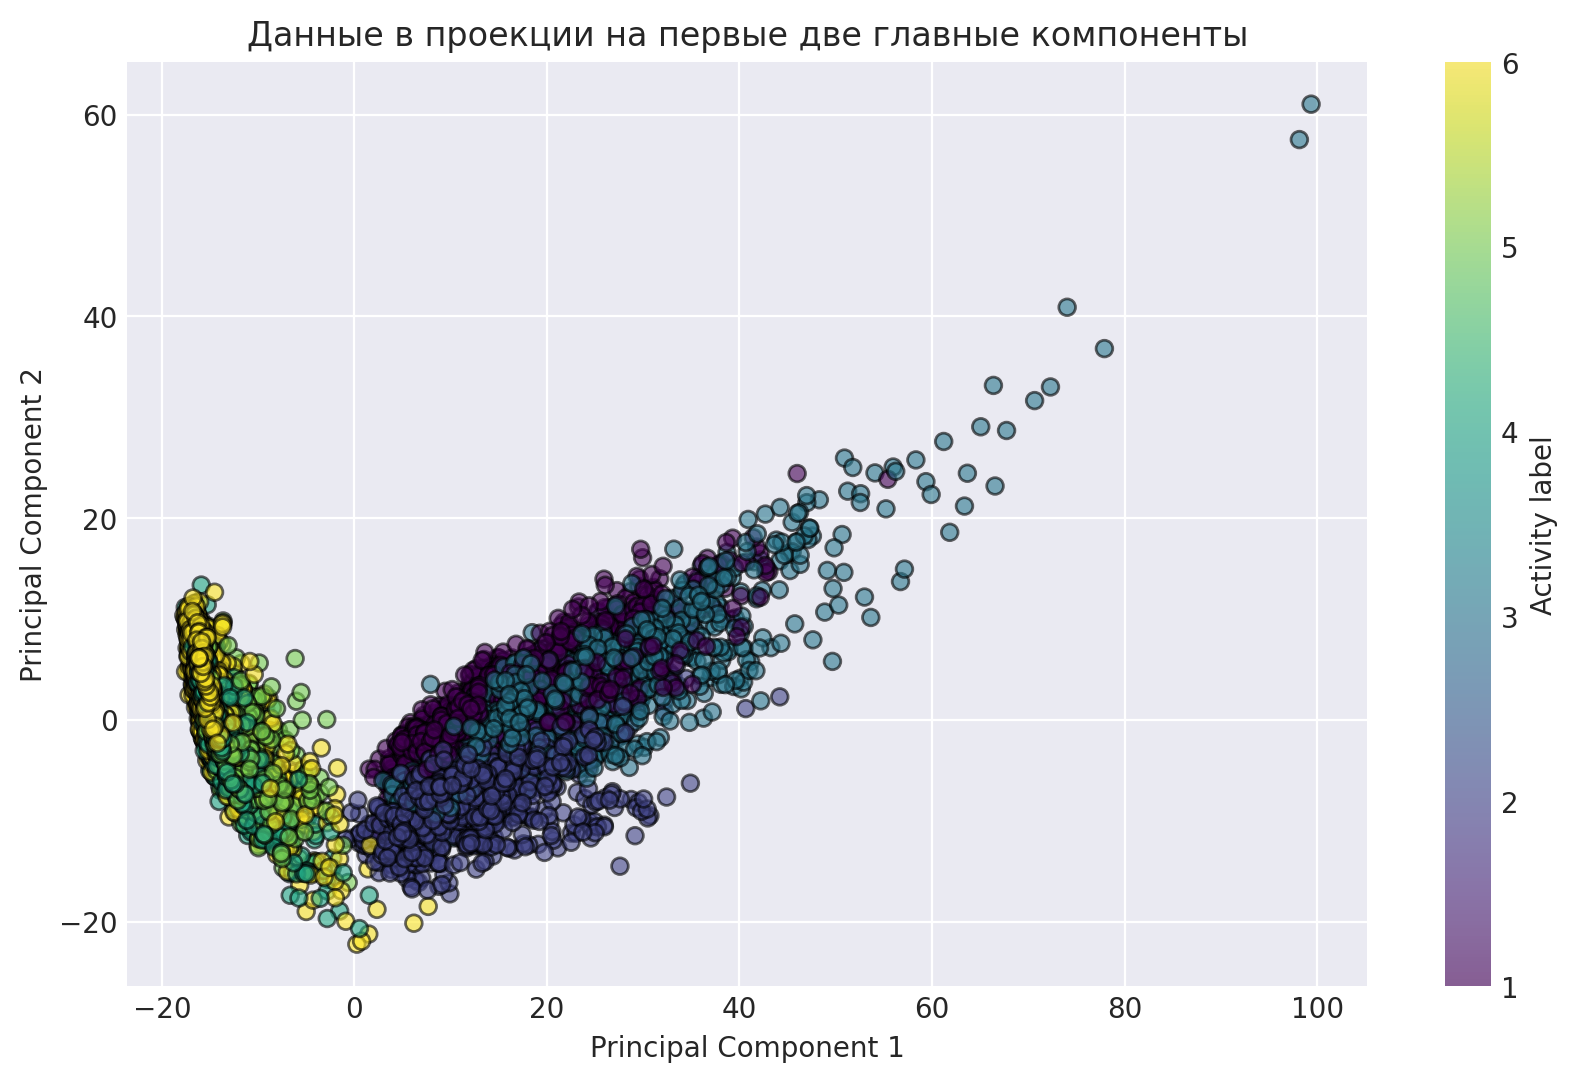

In [378]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y.values.ravel(),
    cmap='viridis',
    alpha=0.6,
    edgecolor='k'
)

plt.colorbar(scatter, label='Activity label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Данные в проекции на первые две главные компоненты')
plt.grid(True)
plt.show()

In [394]:
n_clusters = 6
n_init = 100
random_state = RANDOM_STATE

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)

# время обучения
start_time = time()
kmeans.fit(X_pca)
training_time = time() - start_time

# время предсказания
start_time = time()
y_pred_kmeans = kmeans.predict(X_pca)
predict_time = time() - start_time

print(f'Время обучения: {training_time:.2f} сек.')
print(f'Время предсказания: {predict_time:.2f} сек.')

Время обучения: 23.57 сек.
Время предсказания: 0.01 сек.


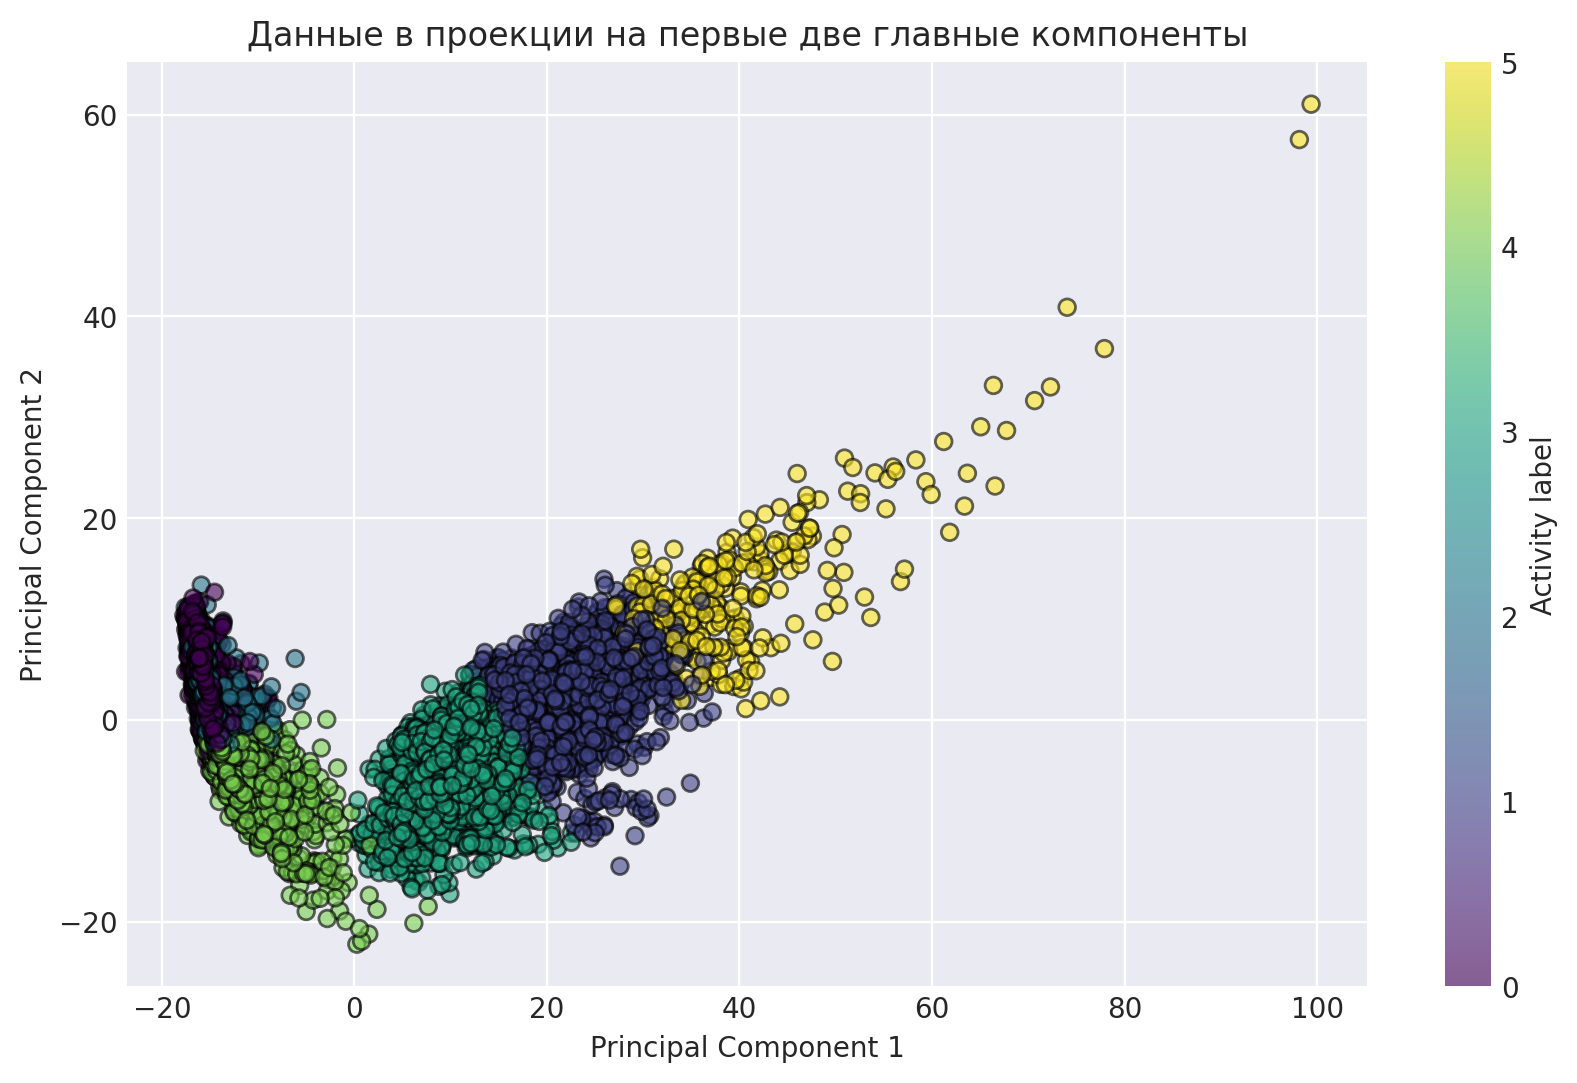

In [395]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_pred_kmeans,
    cmap='viridis',
    alpha=0.6,
    edgecolor='k'
)

plt.colorbar(scatter, label='Activity label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Данные в проекции на первые две главные компоненты')
plt.grid(True)
plt.show()

In [398]:
y_true = y.values.ravel()

ari_kmeans = adjusted_rand_score(y_true, y_pred_kmeans)
nmi_kmeans = normalized_mutual_info_score(y_true, y_pred_kmeans)
silhouette_kmeans = silhouette_score(X_pca, y_pred_kmeans)

print("KMeans метрики:")
print(f"Adjusted Rand Index: {ari_kmeans:.3f}")
print(f"Normalized Mutual Info: {nmi_kmeans:.3f}")
print(f"Silhouette Score: {silhouette_kmeans:.3f}")

KMeans метрики:
Adjusted Rand Index: 0.419
Normalized Mutual Info: 0.560
Silhouette Score: 0.141


ARI - Измеряет схожесть кластеров с истинными классами (0 - случайное совпадение, 1 - идеальное совпадение)\
NMI - Оценивает согласованность кластеров и истинных классов (0 - независимы, 1 - идеально согласованы)\
Silhouette Score - Оценивает плотность кластеров (-1 до 1, выше лучше)


У нас кластеры сильно пересекаются и имеют плохую стуктуру.

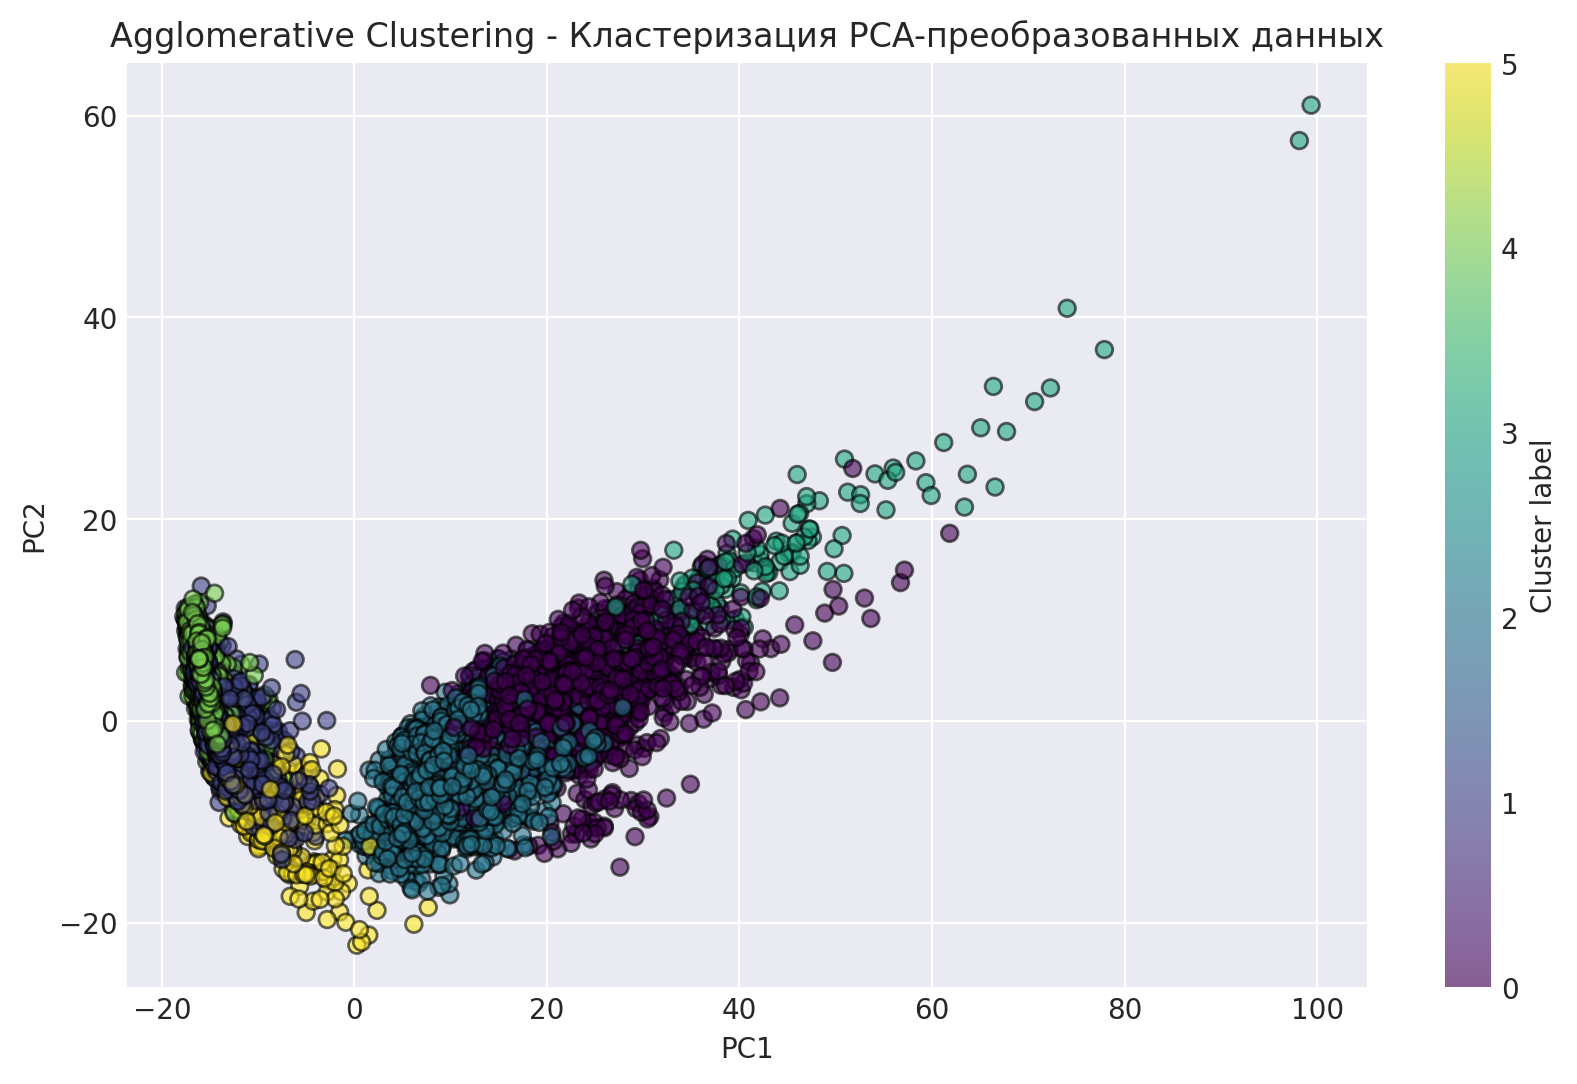

In [404]:
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=6)

start_time = time()
agg_labels = agg_clustering.fit_predict(X_pca)
training_time_agg = time() - start_time

# Визуализация Agglomerative
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=agg_labels,
    cmap='viridis',
    alpha=0.6,
    edgecolor='k'
)
plt.colorbar(scatter, label='Cluster label')
plt.title('Agglomerative Clustering - Кластеризация PCA-преобразованных данных')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [403]:
# Метрики для Agglomerative
ari_agg = adjusted_rand_score(y_true, agg_labels)
nmi_agg = normalized_mutual_info_score(y_true, agg_labels)
silhouette_agg = silhouette_score(X_pca, agg_labels)

print("Agglomerative Метрики:")
print(f"Adjusted Rand Index: {ari_agg:.3f}")
print(f"Normalized Mutual Info: {nmi_agg:.3f}")
print(f"Silhouette Score: {silhouette_agg:.3f}")
print(f"Training time: {training_time_agg:.2f} sec")

Agglomerative Метрики:
Adjusted Rand Index: 0.494
Normalized Mutual Info: 0.622
Silhouette Score: 0.137
Training time: 14.75 sec


1) Стало лучше, но незначительно. Agglomerative показал немного лучшие ARI и NMI, но худший Silhouette Score\
2) Есть несколько ответов на вопрос: "почему?":
* Иерархическая кластеризация лучше улавливает локальные структуры в данных
* По графикам видно, что данные не образуют четко выраженной стрктуры, возможно, поэтому метрики такие низкие.

### **Теперь кластеризация**


In [8]:
from PIL import Image
try:
    duck_img = Image.open('/content/duck.jpg')
    owls_img = Image.open('/content/Owls.jpg')
except FileNotFoundError:
    print("Ошибка: Файлы изображений не найдены. Убедитесь, что duck.jpg и owls.jpg находятся в текущей директории.")
    exit()

In [9]:
# Проверка загрузки
print(f"Утка: {duck_img.format} ({duck_img.size[0]}x{duck_img.size[1]})")
print(f"Совы: {owls_img.format} ({owls_img.size[0]}x{owls_img.size[1]})")

Утка: JPEG (933x700)
Совы: JPEG (1920x1271)


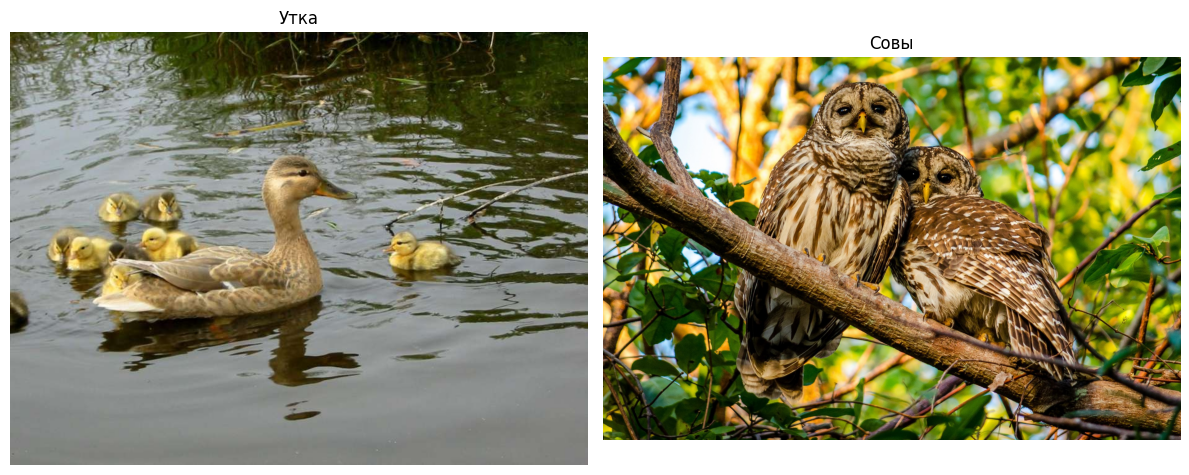

In [10]:
# Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(duck_img)
plt.title('Утка')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(owls_img)
plt.title('Совы')
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def find_components(image, lmbd, n_clusters):
    img = np.array(image)
    height, width, _ = img.shape

    x = np.arange(width).reshape(1, -1)
    y = np.arange(height).reshape(-1, 1)
    x_grid = np.tile(x, (height, 1))
    y_grid = np.tile(y, (1, width))

    # Нормализуем координаты в диапазон [0, 1]
    x_norm = x_grid / (width - 1)
    y_norm = y_grid / (height - 1)

    # Нормализуем цветовые компоненты в диапазон [0, 1]
    r = img[..., 0].astype(np.float32) / 255.0
    g = img[..., 1].astype(np.float32) / 255.0
    b = img[..., 2].astype(np.float32) / 255.0

    # Формируем признаки: [λx, λy, r, g, b]
    features = np.stack([
        lmbd * x_norm,
        lmbd * y_norm,
        r,
        g,
        b
    ], axis=-1).reshape(-1, 5)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)

    centroid_colors = kmeans.cluster_centers_[:, 2:]
    centroid_colors = np.clip(centroid_colors * 255, 0, 255).astype(np.uint8)

    segmented = centroid_colors[labels].reshape(height, width, 3)

    return segmented

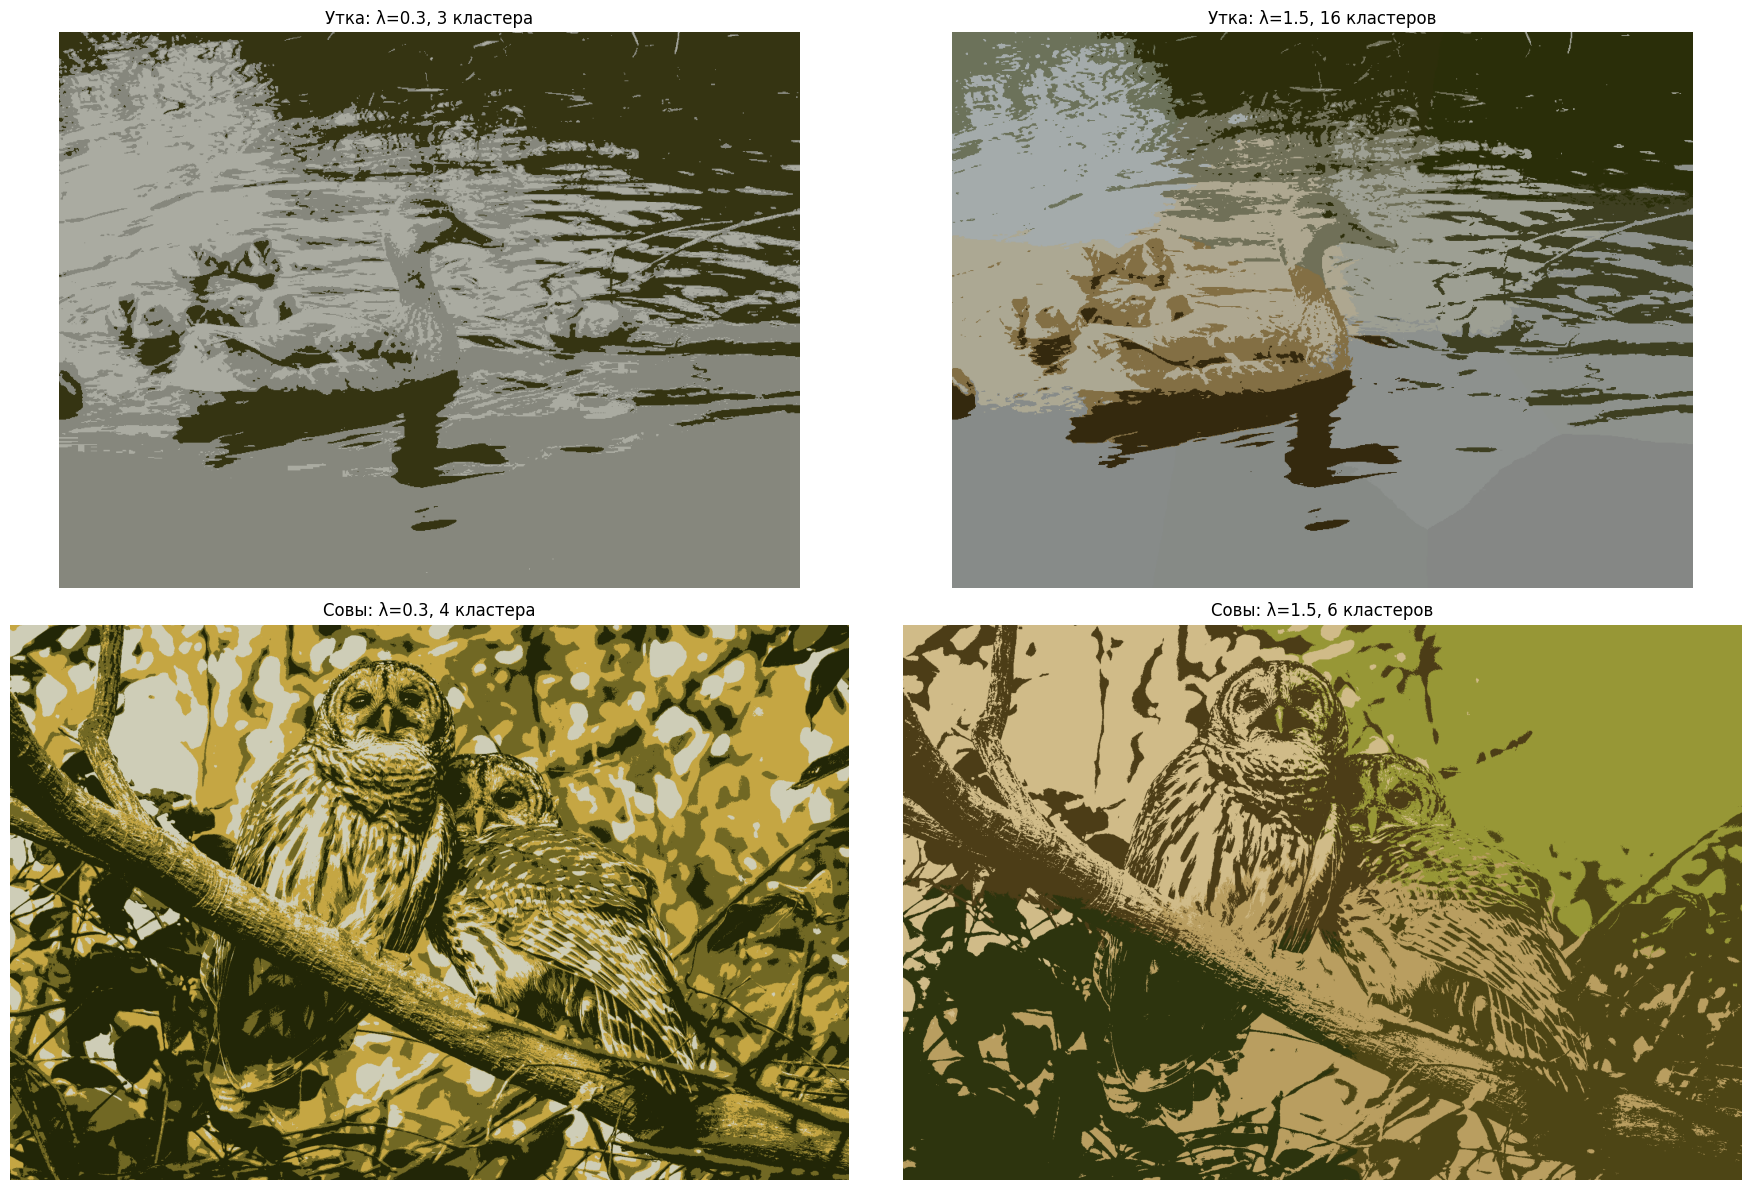

In [17]:
plt.figure(figsize=(18, 12))

# Обработка утки с lambda=0.3
plt.subplot(2, 2, 1)
plt.imshow(find_components(duck_img, lmbd=0.3, n_clusters=3))
plt.title('Утка: λ=0.3, 3 кластера')
plt.axis('off')

# Обработка утки с lambda=1.5
plt.subplot(2, 2, 2)
plt.imshow(find_components(duck_img, lmbd=1.5, n_clusters=16))
plt.title('Утка: λ=1.5, 16 кластеров')
plt.axis('off')

# Обработка сов с lambda=0.3
plt.subplot(2, 2, 3)
plt.imshow(find_components(owls_img, lmbd=0.3, n_clusters=4))
plt.title('Совы: λ=0.3, 4 кластера')
plt.axis('off')

# Обработка сов с lambda=1.5
plt.subplot(2, 2, 4)
plt.imshow(find_components(owls_img, lmbd=1.5, n_clusters=6))
plt.title('Совы: λ=1.5, 6 кластеров')
plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
from skimage import color, transform
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image as img_features

In [25]:
def spectral_segmentation(image, n_clusters, beta=1.0, eps=1e-6, downscale_factor=2):
    img = np.array(image)
    img_gray = color.rgb2gray(img)

    if downscale_factor > 1:
        img_resized = transform.resize(
            img_gray,
            (img.shape[0]//downscale_factor, img.shape[1]//downscale_factor),
            anti_aliasing=True
        )
    else:
        img_resized = img_gray

    graph = img_features.img_to_graph(img_resized)
    graph.data = np.exp(-beta * graph.data / graph.data.std())
    graph.data[graph.data < eps] = 0

    sc = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        n_init=10,
        random_state=42
    )

    labels = sc.fit_predict(graph)

    if downscale_factor > 1:
        labels = labels.reshape(img_resized.shape)
        labels = transform.resize(
            labels,
            (img.shape[0], img.shape[1]),
            order=0,
            preserve_range=True
        ).astype(int)
    else:
        labels = labels.reshape(img.shape[:2])
    segmented_image = (labels / (n_clusters - 1) * 255).astype(np.uint8)

    return segmented_image

In [ ]:
plt.figure(figsize=(18, 12))

# Обработка утки
duck_labels = spectral_segmentation(duck_img, n_clusters=4, beta=0.5, eps=1e-5, downscale_factor=2)

plt.subplot(2, 2, 1)
plt.imshow(duck_labels, cmap='viridis')
plt.title('Спектральная сегментация утки (4 кластера)')
plt.axis('off')

# Обработка сов
owls_labels = spectral_segmentation(owls_img, n_clusters=5, beta=0.3, eps=1e-6, downscale_factor=3)

plt.subplot(2, 2, 2)
plt.imshow(owls_labels, cmap='plasma')
plt.title('Спектральная сегментация сов (5 кластеров)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Применение KMeans сегментации
kmeans_duck = find_components(duck_img, lmbd=1.5, n_clusters=5)
kmeans_owls = find_components(owls_img, lmbd=1.5, n_clusters=6)

# Применение спектральной кластеризации
spectral_duck = spectral_segmentation(duck_img, n_clusters=5, beta=0.5, downscale_factor=2)
spectral_owls = spectral_segmentation(owls_img, n_clusters=6, beta=0.3, downscale_factor=3)

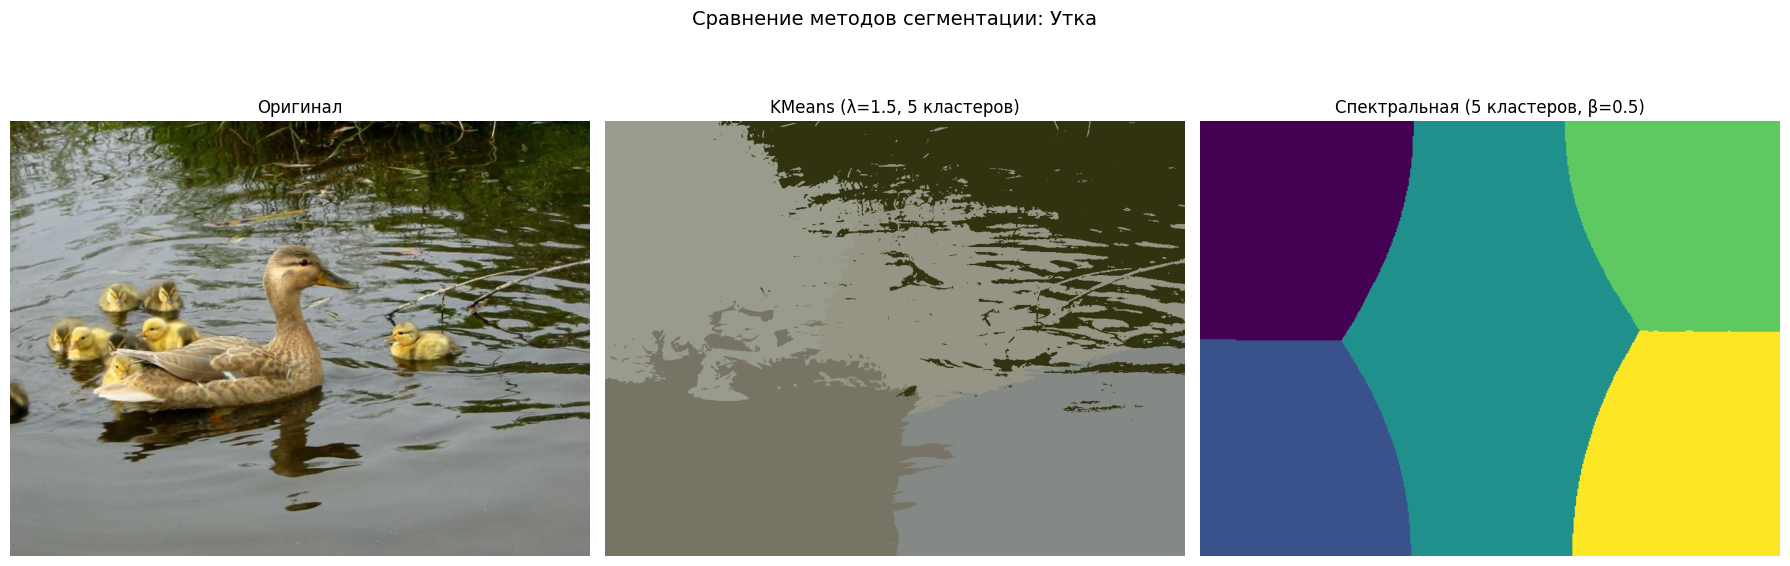

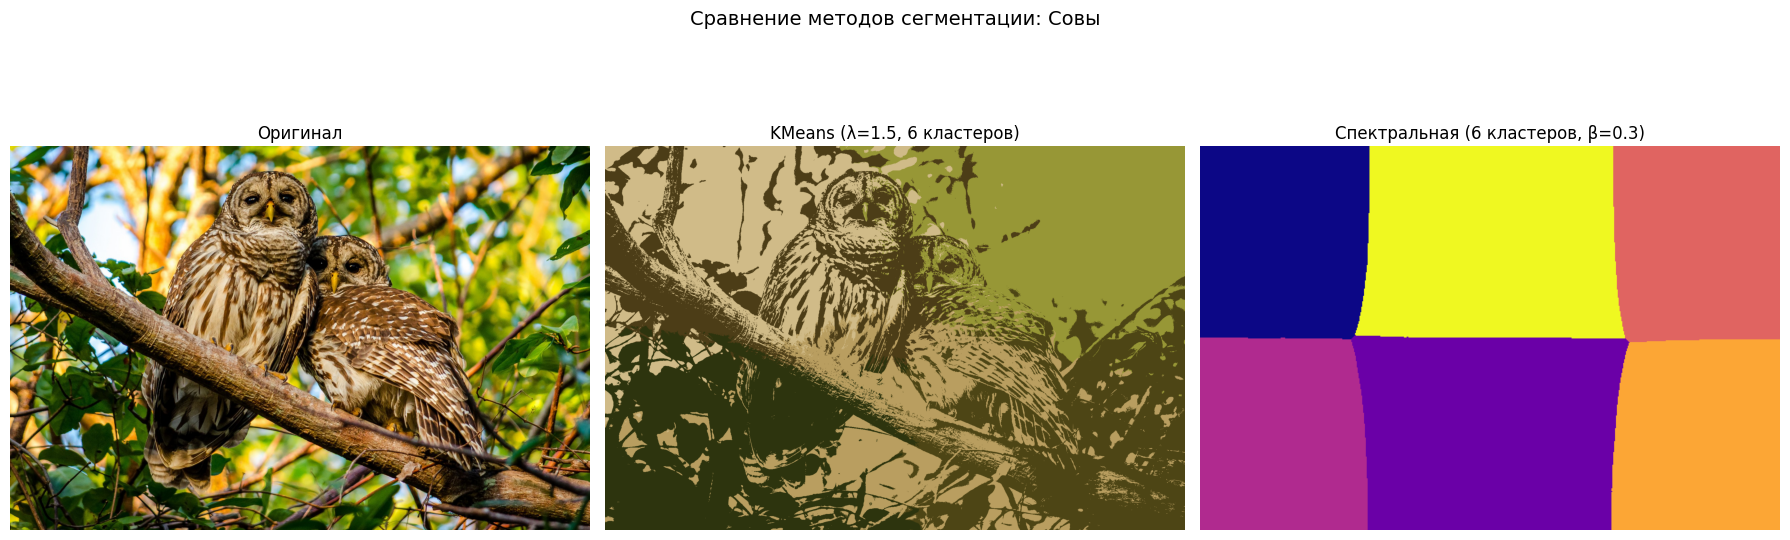

In [24]:
# Визуализация утки
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(duck_img)
plt.title('Оригинал', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kmeans_duck)
plt.title('KMeans (λ=1.5, 5 кластеров)', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(spectral_duck, cmap='viridis')
plt.title('Спектральная (5 кластеров, β=0.5)', fontsize=12)
plt.axis('off')

plt.suptitle('Сравнение методов сегментации: Утка', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# Визуализация сов
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(owls_img)
plt.title('Оригинал', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kmeans_owls)
plt.title('KMeans (λ=1.5, 6 кластеров)', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(spectral_owls, cmap='plasma')
plt.title('Спектральная (6 кластеров, β=0.3)', fontsize=12)
plt.axis('off')

plt.suptitle('Сравнение методов сегментации: Совы', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()